The data from this exercise comes from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation For more details on the data set see the included documentation.

In [1]:
# Ensure that Aequitas dependency is installed
#!pip install aequitas==0.42

In [2]:
from aequitas.plotting import Plot
import pandas as pd

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ap = Plot()

In [3]:
df = pd.read_csv("./data/car.csv")
df.head()

,buying,maint,doors,persons,lug_boot,safety,car
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
df.car.value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: car, dtype: int64

In [5]:
# We'll modify the data to make it a binary problem of acceptable or unacceptable car.
df = df.where(df != 'good', 'acc')
df = df.where(df != 'vgood', 'acc')

y = df.pop('car')
X = df

df.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Use this later to construct the DataFrame Aequitas requires.
df_aq = X_test.reset_index(drop=True).copy()

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_train = ohe.fit_transform(X_train.values)
X_test = ohe.transform(X_test.values)

lb = LabelBinarizer()
y_train = label_binarize(y_train.values, classes=['unacc', 'acc']).ravel()
y_test = label_binarize(y_test.values, classes=['unacc', 'acc']).ravel()

X_train shape:  (1296, 6)
X_test shape:  (432, 6)


In [7]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

scores = lr.predict_proba(X_test)
pred = lr.predict(X_test)

f1 = f1_score(y_test, pred)
print(f"F1 score: {f1:.4f}")

F1 score: 0.8960


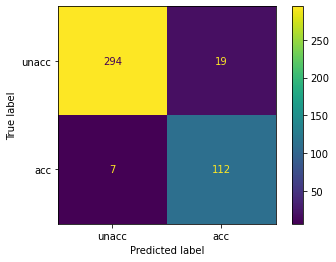

In [11]:
cm = confusion_matrix(y_test, pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["unacc", "acc"]).plot()

In [12]:
# Construct the dataframe that Aequitas will use.
# You can draw inspiration from examples present here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb
df_aq['label_value'] = y_test
df_aq['score'] = pred
df_aq.head()

,buying,maint,doors,persons,lug_boot,safety,label_value,score
0,med,low,5more,4,small,low,0,0
1,high,vhigh,3,more,small,low,0,0
2,low,low,4,4,med,high,1,1
3,low,high,3,4,med,med,1,1
4,vhigh,high,5more,4,big,high,0,1


It is always a good idea to see how predictions are distributed across the categories of features. For example, for cars that can seat only 2 persons are always correctly classified as unacceptable. Cars that have low safety are also always classified as unacceptable.
This can cause some statistics (False Positive Rate, False Negative Rate) to be zero or NAN because there are no false positives or false negatives.
For the persons column, we can show this behavior below.

In [13]:
pd.crosstab(df_aq.score, df_aq.persons)

persons,2,4,more
score,,,
0,143,79,79
1,0,70,61


In [14]:
pd.crosstab(df_aq.label_value, df_aq.persons)

persons,2,4,more
label_value,,,
0,143,87,83
1,0,62,57


In [16]:
# select predictions for cars that can seat only 2 persons
y_test_person_eq_2 = y_test[df_aq.loc[df_aq.persons == "2"].index]
y_pred_person_eq_2 = pred[df_aq.loc[df_aq.persons == "2"].index]

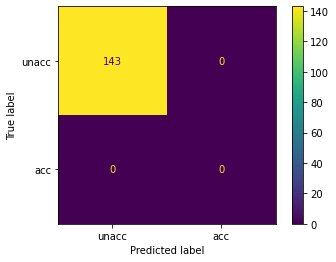

In [17]:
cm_person_eq_2 = confusion_matrix(y_test_person_eq_2, y_pred_person_eq_2, labels=[0, 1])
ConfusionMatrixDisplay(cm_person_eq_2, display_labels=["unacc", "acc"]).plot()

In [18]:
# Run Aequitas
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
xtab.head()

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,131,buying,high,0.913043,0.900000,0.024096,0.300000,0.100000,0.086957,0.975904,0.700000,30,83,0.229008,0.265487,9,2,81,21,23,90,113,432,0.203540
1,0,binary 0/1,131,buying,low,0.972973,0.963636,0.018519,0.052632,0.036364,0.027027,0.981481,0.947368,38,54,0.290076,0.413043,2,1,53,36,37,55,92,432,0.402174
2,0,binary 0/1,131,buying,med,1.000000,0.946667,0.000000,0.088889,0.053333,0.000000,1.000000,0.911111,45,71,0.343511,0.387931,4,0,71,41,41,75,116,432,0.353448
3,0,binary 0/1,131,buying,vhigh,0.777778,0.956989,0.043011,0.222222,0.043011,0.222222,0.956989,0.777778,18,93,0.137405,0.162162,4,4,89,14,18,93,111,432,0.162162
4,0,binary 0/1,131,maint,high,0.896552,0.929412,0.036585,0.187500,0.070588,0.103448,0.963415,0.812500,32,82,0.244275,0.280702,6,3,79,26,29,85,114,432,0.254386


In [19]:
bias = Bias()
bias_df = bias.get_disparity_major_group(xtab,original_df=df_aq, 
                                         alpha=0.05, 
                                         mask_significance=True)
bias_df.head()

get_disparity_major_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,131,buying,high,0.913043,0.900000,0.024096,0.300000,0.100000,0.086957,0.975904,0.700000,30,83,0.229008,0.265487,9,2,81,21,23,90,113,432,0.203540,0.666667,0.684366,0.768293,3.375000,10.0,1.875000,10.0,0.913043,0.950704,0.975904,med,med,med,med,med,med,med,med,med,med
1,0,binary 0/1,131,buying,low,0.972973,0.963636,0.018519,0.052632,0.036364,0.027027,0.981481,0.947368,38,54,0.290076,0.413043,2,1,53,36,37,55,92,432,0.402174,0.844444,1.064734,1.039795,0.592105,10.0,0.681818,10.0,0.972973,1.017926,0.981481,med,med,med,med,med,med,med,med,med,med
2,0,binary 0/1,131,buying,med,1.000000,0.946667,0.000000,0.088889,0.053333,0.000000,1.000000,0.911111,45,71,0.343511,0.387931,4,0,71,41,41,75,116,432,0.353448,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,1.000000,med,med,med,med,med,med,med,med,med,med
3,0,binary 0/1,131,buying,vhigh,0.777778,0.956989,0.043011,0.222222,0.043011,0.222222,0.956989,0.777778,18,93,0.137405,0.162162,4,4,89,14,18,93,111,432,0.162162,0.400000,0.418018,0.853659,2.500000,10.0,0.806452,10.0,0.777778,1.010904,0.956989,med,med,med,med,med,med,med,med,med,med
4,0,binary 0/1,131,maint,high,0.896552,0.929412,0.036585,0.187500,0.070588,0.103448,0.963415,0.812500,32,82,0.244275,0.280702,6,3,79,26,29,85,114,432,0.254386,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,high,high,high,high,high,high,high,high,high,high


In [21]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)
fairness_df.head()

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,131,buying,high,0.913043,0.900000,0.024096,0.300000,0.100000,0.086957,0.975904,0.700000,30,83,0.229008,0.265487,9,2,81,21,23,90,113,432,0.203540,0.666667,0.684366,0.768293,3.375000,10.0,1.875000,10.0,0.913043,0.950704,0.975904,med,med,med,med,med,med,med,med,med,med,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False
1,0,binary 0/1,131,buying,low,0.972973,0.963636,0.018519,0.052632,0.036364,0.027027,0.981481,0.947368,38,54,0.290076,0.413043,2,1,53,36,37,55,92,432,0.402174,0.844444,1.064734,1.039795,0.592105,10.0,0.681818,10.0,0.972973,1.017926,0.981481,med,med,med,med,med,med,med,med,med,med,True,True,False,False,False,False,True,True,True,True,False,False,False,True,False
2,0,binary 0/1,131,buying,med,1.000000,0.946667,0.000000,0.088889,0.053333,0.000000,1.000000,0.911111,45,71,0.343511,0.387931,4,0,71,41,41,75,116,432,0.353448,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN,1.000000,1.000000,1.000000,med,med,med,med,med,med,med,med,med,med,True,True,True,True,NaN,NaN,True,True,True,True,True,NaN,True,True,False
3,0,binary 0/1,131,buying,vhigh,0.777778,0.956989,0.043011,0.222222,0.043011,0.222222,0.956989,0.777778,18,93,0.137405,0.162162,4,4,89,14,18,93,111,432,0.162162,0.400000,0.418018,0.853659,2.500000,10.0,0.806452,10.0,0.777778,1.010904,0.956989,med,med,med,med,med,med,med,med,med,med,False,False,False,True,False,False,False,True,True,True,False,False,False,False,False
4,0,binary 0/1,131,maint,high,0.896552,0.929412,0.036585,0.187500,0.070588,0.103448,0.963415,0.812500,32,82,0.244275,0.280702,6,3,79,26,29,85,114,432,0.254386,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,high,high,high,high,high,high,high,high,high,high,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [22]:
overall_fairness = fairness.get_overall_fairness(fairness_df)
print(overall_fairness)

{'Unsupervised Fairness': False, 'Supervised Fairness': False, 'Overall Fairness': False}


In [23]:
metrics = ['fpr', "for", "fnr"]
disparity_metrics = [f"{metric}_disparity" for metric in metrics]

In [24]:
# Just as we discussed above, some statistics are zero or NAN
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics]

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,buying,high,0.100000,0.024096,0.086957,1.875000,10.000000,10.000000
1,buying,low,0.036364,0.018519,0.027027,0.681818,10.000000,10.000000
2,buying,med,0.053333,0.000000,0.000000,1.000000,NaN,NaN
3,buying,vhigh,0.043011,0.043011,0.222222,0.806452,10.000000,10.000000
4,maint,high,0.070588,0.036585,0.103448,1.000000,1.000000,1.000000
5,maint,low,0.083333,0.029412,0.051282,1.180556,0.803922,0.495726
6,maint,med,0.076923,0.032258,0.052632,1.089744,0.881720,0.508772
7,maint,vhigh,0.021978,0.000000,0.000000,0.311355,0.000000,0.000000
8,doors,2,0.061728,0.037975,0.150000,0.987654,0.987342,1.900000
9,doors,3,0.062500,0.038462,0.078947,1.000000,1.000000,1.000000


In [25]:
# To avoid issues when plotting, add an epilon (0.000001) to cases where statistics are zero or NAN
eps = 0.000001
bias_df[disparity_metrics] = bias_df[disparity_metrics].fillna(0.0) + eps

In [26]:
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics]

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,buying,high,0.100000,0.024096,0.086957,1.875001,10.000001,10.000001
1,buying,low,0.036364,0.018519,0.027027,0.681819,10.000001,10.000001
2,buying,med,0.053333,0.000000,0.000000,1.000001,0.000001,0.000001
3,buying,vhigh,0.043011,0.043011,0.222222,0.806453,10.000001,10.000001
4,maint,high,0.070588,0.036585,0.103448,1.000001,1.000001,1.000001
5,maint,low,0.083333,0.029412,0.051282,1.180557,0.803923,0.495727
6,maint,med,0.076923,0.032258,0.052632,1.089745,0.881721,0.508773
7,maint,vhigh,0.021978,0.000000,0.000000,0.311356,0.000001,0.000001
8,doors,2,0.061728,0.037975,0.150000,0.987655,0.987343,1.900001
9,doors,3,0.062500,0.038462,0.078947,1.000001,1.000001,1.000001


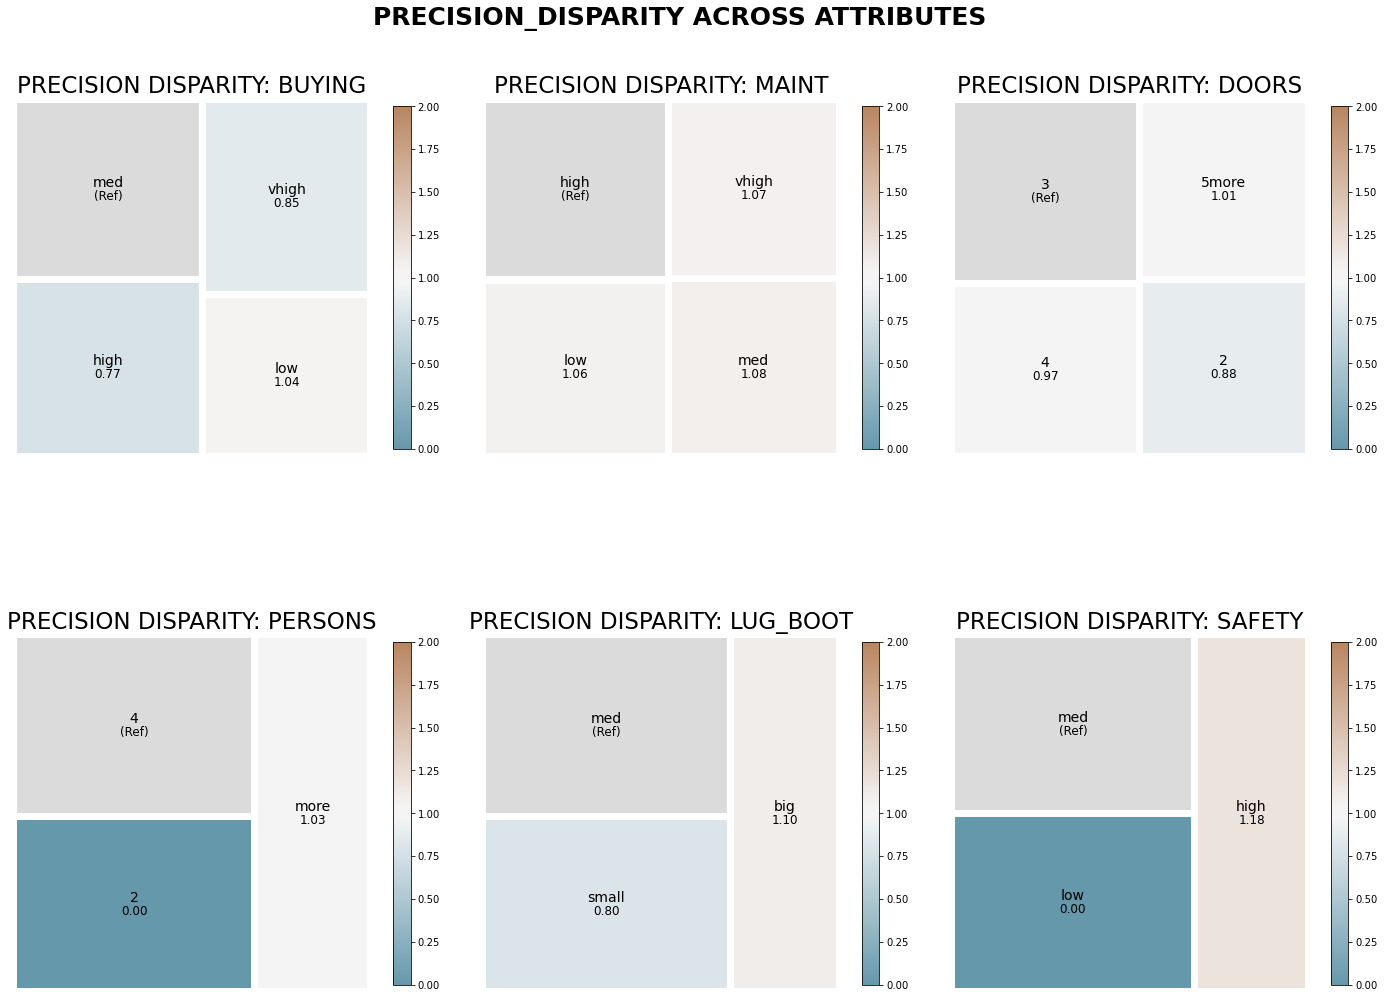

In [27]:
disparity_tolerance = 1.25

# Deprecated function summary()
# ap.summary(bias_df, metrics, fairness_threshold=disparity_tolerance)

# Aequitas Fairness() class provides a few functions that provide a high level summary of fairness and disparity, such as 
# plot_fairness_group()
# plot_fairness_group_all()
# plot_fairness_disparity()
# plot_fairness_disparity_all()
# plot_disparity()
# See some example here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb 
p = ap.plot_disparity_all(bias_df, metrics=['precision_disparity'], significance_alpha=0.05)
